# Looked After Children (LAC) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import plotly.express as px
import json
import geopandas as gpd
import mapclassify
import folium
from scipy import stats
import contextily as ctx
import libpysal
from pysal.explore import esda
from esda.moran import Moran, Moran_Local
from libpysal.weights import Queen, Rook
from splot.esda import plot_local_autocorrelation, lisa_cluster
import statsmodels.api as sm

import sys
sys.path.append('../code')
from data_cleaning import gender_mapping

import warnings
warnings.filterwarnings('ignore')

plt.style.use('tableau-colorblind10')
color='#702A7D'

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH lac_WithAddress AS (
  SELECT
    lac.person_id,
    lac.StartDate,
    lac.EndDate,
    lac.EthnicOrigin,
    DATE(p.birth_datetime) AS DateOfBirth,
    p.gender_source_value AS Gender,
    a.SOA AS LSOA,
    /* For each lac row, rank the joined address rows 
       (if any) by DateEventRecorded (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY lac.person_id, lac.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiC` lac
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON lac.person_id = a.person_id
      AND DATE(a.DateEvent) <= lac.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON lac.person_id = p.person_id
)
SELECT 
  person_id,
  Gender,      
  StartDate,
  EndDate,
  EthnicOrigin,
  DateOfBirth,
  LSOA
FROM
  lac_WithAddress
WHERE 
  rn = 1;
"""

# Load Query into Pandas Dataframe

In [4]:
lac = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████|


In [5]:
# Information about the columns
lac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   person_id     1917 non-null   object
 1   Gender        1910 non-null   object
 2   StartDate     1917 non-null   dbdate
 3   EndDate       961 non-null    dbdate
 4   EthnicOrigin  1917 non-null   object
 5   DateOfBirth   1911 non-null   dbdate
 6   LSOA          1333 non-null   object
dtypes: dbdate(3), object(4)
memory usage: 105.0+ KB


In [6]:
# Count number of missing values
missing_values = lac.isnull().sum()
total_values = lac.shape[0]
percentage_missing = round(missing_values/total_values*100, 2)
percentage_missing

person_id        0.00
Gender           0.37
StartDate        0.00
EndDate         49.87
EthnicOrigin     0.00
DateOfBirth      0.31
LSOA            30.46
dtype: float64

In [7]:
# Strip whitespace from all string/object columns
lac = lac.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [8]:
# Clean gender column
gender_mapping(lac, 'Gender')

array(['Female', 'Male', nan, None], dtype=object)

# Load Bradford Children Population Data 0-17 years, 2021.
source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates

In [9]:
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)
population_data.columns

Index(['LAD 2021 Code', 'LAD 2021 Name', 'LSOA 2021 Code', 'LSOA 2021 Name',
       'TotalPop', 'FemalePop', 'MalePop'],
      dtype='object')

# Load Bradford Boundary Data
source: https://borders.ukdataservice.ac.uk/

In [10]:
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradord_boundary_data = gpd.read_file(boundary_data_filepath)

# Print data type and crs
print(type(bradord_boundary_data))
print(bradord_boundary_data.crs)
print(bradord_boundary_data.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:27700
Index(['lsoa21cd', 'lsoa21nm', 'label', 'name', 'geometry'], dtype='object')


# Load Index of Multiple Deprivation (IMD) Data
source: https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd

In [11]:
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd = gpd.read_file(imd_filepath)

In [12]:
# Display the columns in the IMD data
imd.columns

Index(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths',
       'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore',
       'IMDRank0', 'IMDDec0', 'IncScore', 'IncRank', 'IncDec', 'EmpScore',
       'EmpRank', 'EmpDec', 'EduScore', 'EduRank', 'EduDec', 'HDDScore',
       'HDDRank', 'HDDDec', 'CriScore', 'CriRank', 'CriDec', 'BHSScore',
       'BHSRank', 'BHSDec', 'EnvScore', 'EnvRank', 'EnvDec', 'IDCScore',
       'IDCRank', 'IDCDec', 'IDOScore', 'IDORank', 'IDODec', 'CYPScore',
       'CYPRank', 'CYPDec', 'ASScore', 'ASRank', 'ASDec', 'GBScore', 'GBRank',
       'GBDec', 'WBScore', 'WBRank', 'WBDec', 'IndScore', 'IndRank', 'IndDec',
       'OutScore', 'OutRank', 'OutDec', 'TotPop', 'DepChi', 'Pop16_59',
       'Pop60+', 'WorkPop', 'geometry'],
      dtype='object')

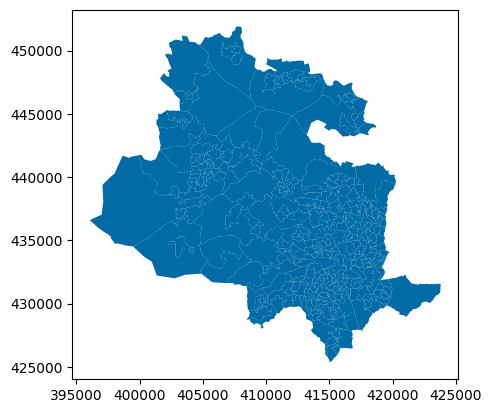

In [13]:
# Display the map

bradord_boundary_data.plot();

In [14]:
# Drop rows where LSOA is missing
lac = lac.dropna(subset=['LSOA'])
lac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 0 to 1916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   person_id     1333 non-null   object
 1   Gender        1332 non-null   object
 2   StartDate     1333 non-null   dbdate
 3   EndDate       658 non-null    dbdate
 4   EthnicOrigin  1333 non-null   object
 5   DateOfBirth   1333 non-null   dbdate
 6   LSOA          1333 non-null   object
dtypes: dbdate(3), object(4)
memory usage: 83.3+ KB


In [15]:
# Convert dates data types 
dates_columns = ['StartDate', 'EndDate', 'DateOfBirth']
lac[dates_columns] = lac[dates_columns].apply(pd.to_datetime)

In [16]:
# Creating New Columns

# Number of Days in Intervention
lac['num_of_days_in_intervention'] = (lac['EndDate'] - lac['StartDate']).dt.days


# Calculate age at entry (completed years)
lac['age_at_entry'] = lac.apply(
    lambda row: relativedelta(row['StartDate'], row['DateOfBirth']).years,
    axis=1
).astype('int')

# Keep rows where age is between 0-17
lac = lac.loc[lac['age_at_entry'] < 18]

# Age Binning
bins = [0, 1, 4, 9, 15, 16]
labels = ['Under 1', '1-4', '5-9', '10-15', '16+']
lac['entry_agegroup'] = pd.cut(lac['age_at_entry'], 
                             bins=bins, 
                             labels=labels,
                             right=True)

In [17]:
# Example of unique LSOA prefixes
lac['lsoa_prefix'] = lac['LSOA'].str[:3]
print(lac['lsoa_prefix'].unique())

['E01' '' 'W01' 'S01']


In [18]:
# Filter lac to keep only English LSOAs (starting with 'E01') and remove empty strings
lac_english_lsoa = lac[lac['LSOA'].str.startswith('E01', na=False)].copy()

print(f"Number of rows in lac before filtering: {len(lac)}")
print(f"Number of rows in lac_english_lsoa after filtering: {len(lac_english_lsoa)}")

Number of rows in lac before filtering: 1331
Number of rows in lac_english_lsoa after filtering: 1159


In [19]:
lac_english_lsoa['LSOA'].nunique()

398

# Merge intervention and boundary data

In [20]:
# 1. Check for missing matches before merging
print("Bradford boundary unique LSOAs:", len(bradord_boundary_data['lsoa21cd'].unique()))
print("lac English unique LSOAs:", len(lac_english_lsoa['LSOA'].unique()))
print("Common LSOAs:", len(set(bradord_boundary_data['lsoa21cd']).intersection(set(lac_english_lsoa['LSOA']))))

# 2. Use left merge to preserve geometry
merged_data = bradord_boundary_data.merge(
    lac_english_lsoa,
    left_on='lsoa21cd',
    right_on='LSOA',
    how='left',
)

# 3. Verify geometry column is preserved
print("Geometry column present:", 'geometry' in merged_data.columns)
print(merged_data.crs)

Bradford boundary unique LSOAs: 312
lac English unique LSOAs: 398
Common LSOAs: 227
Geometry column present: True
EPSG:27700


<Axes: >

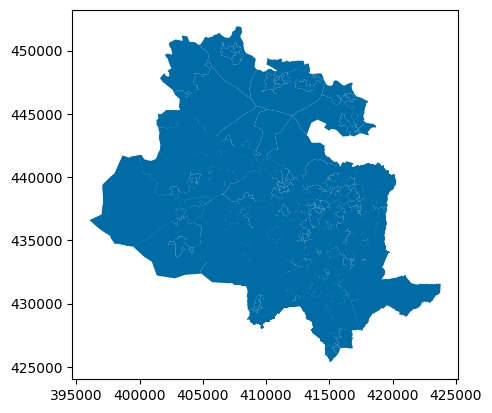

In [21]:
# Confirm the map plot
merged_data.plot()

In [22]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   lsoa21cd                     991 non-null    object        
 1   lsoa21nm                     991 non-null    object        
 2   label                        991 non-null    object        
 3   name                         991 non-null    object        
 4   geometry                     991 non-null    geometry      
 5   person_id                    906 non-null    object        
 6   Gender                       905 non-null    object        
 7   StartDate                    906 non-null    datetime64[ns]
 8   EndDate                      473 non-null    datetime64[ns]
 9   EthnicOrigin                 906 non-null    object        
 10  DateOfBirth                  906 non-null    datetime64[ns]
 11  LSOA                         906 non-

In [23]:
# Drop unwanted columns
columns_to_drop = ['lsoa21nm', 'label', 'LSOA']
merged_data.drop(columns=columns_to_drop, inplace=True)

#### Number of LAC per LSOA - Is there a significant variation in number of LAC across LSOAs

In [24]:
# Group by LSOA and count the number of children
children_per_lsoa = merged_data.groupby('lsoa21cd', as_index=False).agg(
    children_count=('lsoa21cd', 'size'),
    geometry=('geometry', 'first')
).pipe(gpd.GeoDataFrame)

# Merge with IMD Data
columns_to_include_from_imd = [
    'lsoa11cd', 'IMD_Decile', 'IMDScore',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec',
    'HDDDec', 'DepChi'
]

children_per_lsoa = children_per_lsoa.merge(
    imd[columns_to_include_from_imd],
    left_on ='lsoa21cd',
    right_on='lsoa11cd',
    how='left'
).drop(columns='lsoa11cd')

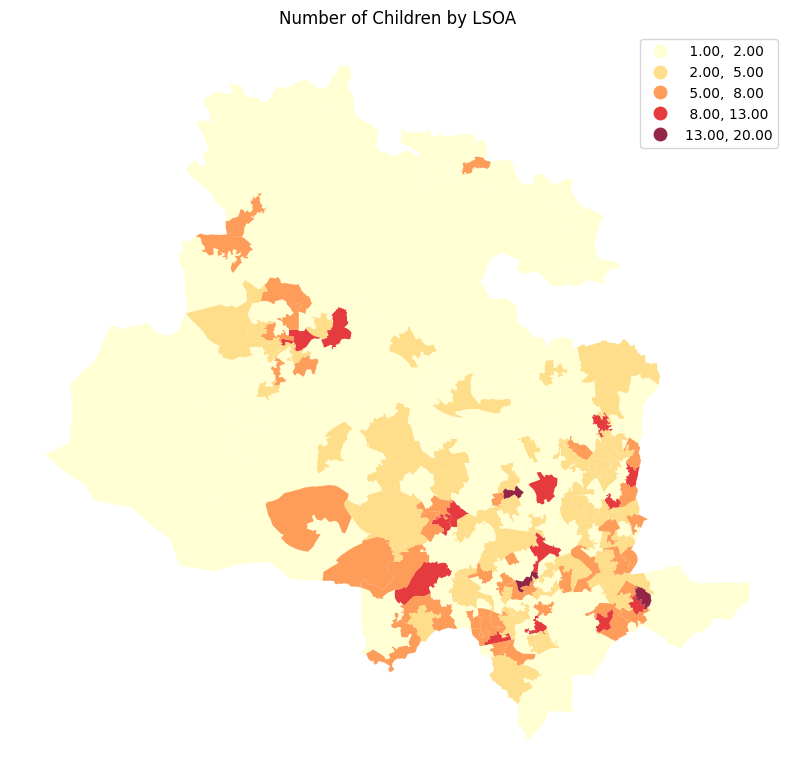

In [25]:
# Step 3: Plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) 

children_per_lsoa.plot(
    ax=ax,                  
    column='children_count',
    scheme='FisherJenks',     
    cmap='YlOrRd',
    alpha=0.85,
    legend=True,            
)

# Remove axis for better visualization
ax.set_axis_off()

# Add a title
ax.set_title("Number of Children by LSOA")

# Show the plot
plt.show()

### LAC Population Rate  by LSOA - Looking at rate helps us balance uneven population across LSOAs

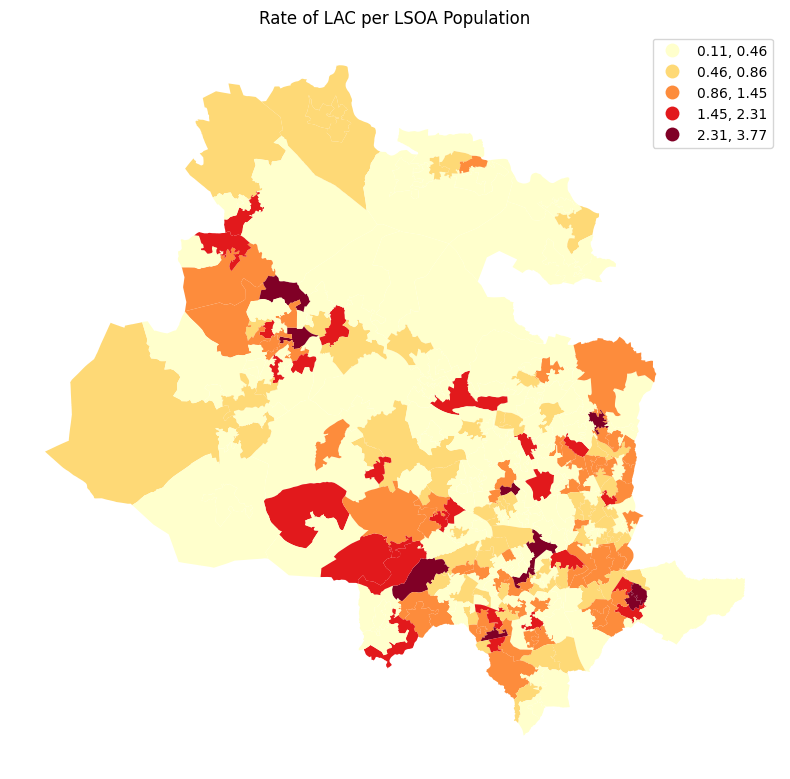

In [41]:
# Merge with population data
children_population = children_per_lsoa.merge(
    population_data[['LSOA 2021 Code', 'TotalPop']],
    left_on='lsoa21cd',
    right_on='LSOA 2021 Code',
    how='left'
).drop(columns='LSOA 2021 Code')

# Calculate children proportion
children_population['children_per_total_pop'] = (
    children_population['children_count'] /
    children_population['TotalPop']) * 100
# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))
# Plot the LAC rate
children_population.plot(
    ax=ax,
    column='children_per_total_pop',
    scheme='NaturalBreaks',
    cmap='YlOrRd',
    legend=True
)
ax.set_axis_off()
ax.set_title('Rate of LAC per LSOA Population')
plt.tight_layout()
plt.savefig("../figs/LAC_intervention_rate_map.png", dpi=300)
plt.show()

### Global Spatial Autocorrelation for LAC Population Rate Using Moran I and Getis-Ord G
* Moran's I asks: "Are similar values near each other?"
* Getis-Ord G asks: "Are high values clustering together, or are low values clustering together?"

In [27]:
from libpysal.weights import KNN
w_queen = Queen.from_dataframe(children_population)
w_queen.transform = 'r' 

# Calculate Moran's I
moran_queen = Moran(children_population['children_per_total_pop'], w_queen)
print("Queen: \n")
print(f"Moran's I: {moran_queen.I}")
print(f"p-value: {moran_queen.p_sim}")
print(f"z-score: {moran_queen.z_sim}")

# KNN 
centroids = children_population.geometry.centroid
coords = list(zip(centroids.x, centroids.y))
w_knn = KNN(coords, k=6)
w_knn.transform = 'r'

moran_knn = Moran(children_population['children_per_total_pop'], w_knn)
print("KNN: \n")
print(f"Moran's I: {moran_knn.I}")
print(f"p-value: {moran_knn.p_sim}")
print(f"z-score: {moran_knn.z_sim}")

Queen: 

Moran's I: 0.11418747401966216
p-value: 0.001
z-score: 3.4406677754487056
KNN: 

Moran's I: 0.09101843134391216
p-value: 0.005
z-score: 3.0369888669511256


In [28]:
# Calculate Getis-Ord G
# Queen weights matrix
print("Getis-Ord G, Queen Weights")
g = esda.getisord.G(children_population['children_per_total_pop'], w_queen)
print(f"Getis-Ord G: {g.G}")
print(f"p-value: {g.p_sim}")
print(f"z-score: {g.z_sim}")

# KNN
print("\nGetis-Ord G, KNN Weights")
g = esda.getisord.G(children_population['children_per_total_pop'], w_knn)
print(f"Getis-Ord G: {g.G}")
print(f"p-value: {g.p_sim}")
print(f"z-score: {g.z_sim}")

Getis-Ord G, Queen Weights
Getis-Ord G: 0.020113744043648175
p-value: 0.004
z-score: 2.741884195507527

Getis-Ord G, KNN Weights
Getis-Ord G: 0.020763023482999274
p-value: 0.011
z-score: 2.6773993940173253


___________
Low Moran I's score suggest spatial randomness. No spatial autocorrelation.<br>
Getis-Ord G: The results shows there are hig value clusters (hot spots) with a confidence level of 96.6%

### Local Autocorrelation with Getis-Ord Gi* and Local Indicators of Spatial Association (LISA)

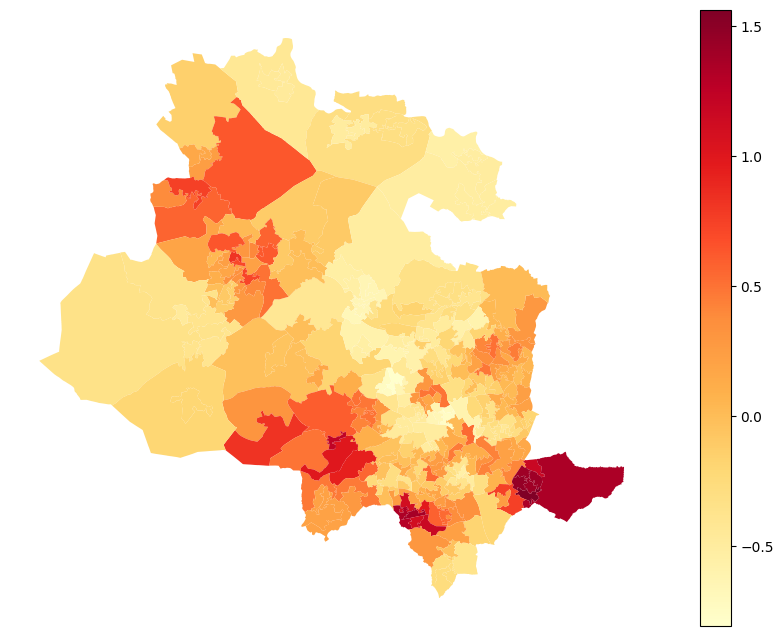

In [29]:
# Hostspot analysis Getis-Ord Gi*
from esda.getisord import G_Local

gi = G_Local(children_population['children_per_total_pop'], w_knn, star=True)
children_population['gi_Zscore'] = gi.Zs
children_population.plot(
    column='gi_Zscore', cmap='YlOrRd',
    legend=True,
    figsize=(12,8)
)
plt.axis('off')
plt.show()

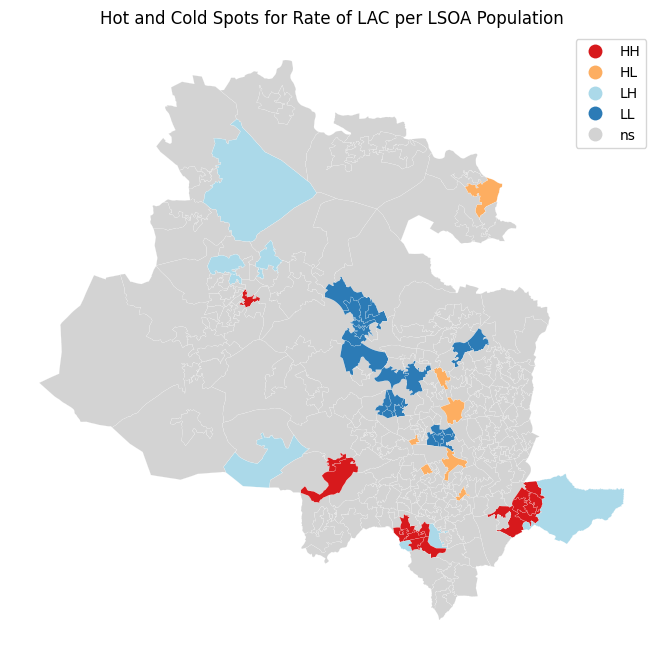

In [30]:
from splot.esda import lisa_cluster
# Local Moran I
lisa = Moran_Local(children_population['children_per_total_pop'], w_knn)

# Plot the local autocorrelation; adjust overall figure size as needed
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
lisa_cluster(lisa, children_population, p=0.05, ax=ax)
ax.set_title("Hot and Cold Spots for Rate of LAC per LSOA Population")
plt.savefig("../figs/lac_hot-cold spots.png", dpi=300)
plt.show()

##### What percentage of LSOAs accounts for what percentage of Children in LAC?

19.2% of LSOAs account for 50% of Looked After children


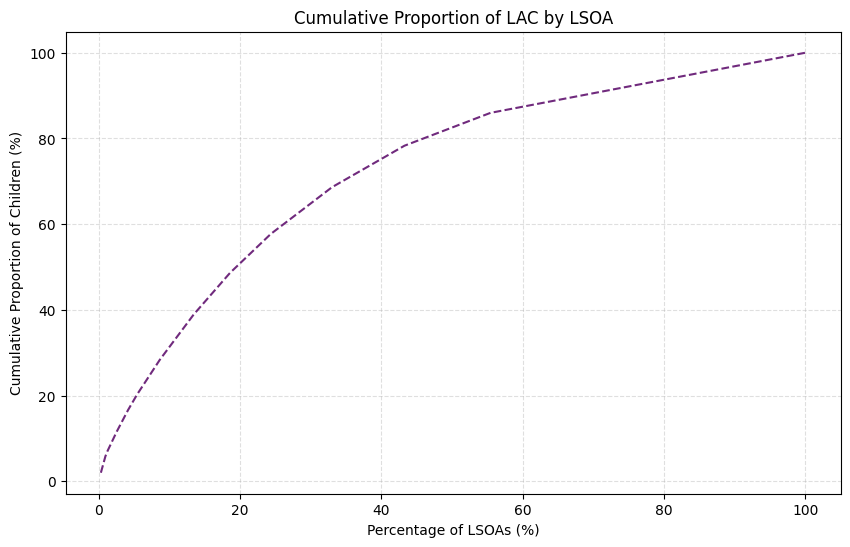

In [42]:
# Number of children
total_children = children_per_lsoa['children_count'].sum()

# Sort by children_count (descending):
children_per_lsoa_sorted = children_per_lsoa.sort_values(by='children_count', ascending=False)

# Calculate the cumulative sum and proportion:
children_per_lsoa_sorted['cumulative_children'] = children_per_lsoa_sorted['children_count'].cumsum()
children_per_lsoa_sorted['cumulative_percent'] = (
    100.0 * children_per_lsoa_sorted['cumulative_children'] / total_children
)

# Find the percentage of LSOAs that account for 50% of children
lsoas_for_50_percent = len(children_per_lsoa_sorted[children_per_lsoa_sorted['cumulative_percent'] <= 50])
percent_lsoas_for_50 = (lsoas_for_50_percent / len(children_per_lsoa_sorted)) * 100

print(f"{percent_lsoas_for_50:.1f}% of LSOAs account for 50% of Looked After children")

# Create an x-axis representing the percentage of LSOAs.
# Each point's x-value is (index position / total LSOAs) * 100
num_lsoas = len(children_per_lsoa_sorted)
x_percent = [(i + 1) / num_lsoas * 100 for i in range(num_lsoas)]

# Plot cumulative proportion vs. number of LSOAs:
plt.figure(figsize=(10, 6))
plt.plot(
    x_percent,
    children_per_lsoa_sorted['cumulative_percent'],
    linestyle='--',
    color=color
)
plt.title('Cumulative Proportion of LAC by LSOA')
plt.xlabel('Percentage of LSOAs (%)')
plt.ylabel('Cumulative Proportion of Children (%)')
plt.grid(True, linestyle='--', alpha=.4)
plt.savefig("../figs/children_proportion_per_LSOAproportion.png", dpi=300)
plt.show()

#### LAC Rate vs. IMD Decile by LSOA -  Is there a relationship btw rate of LAC and the IMD rank of the LSOA = are more LAC in deprived areas?

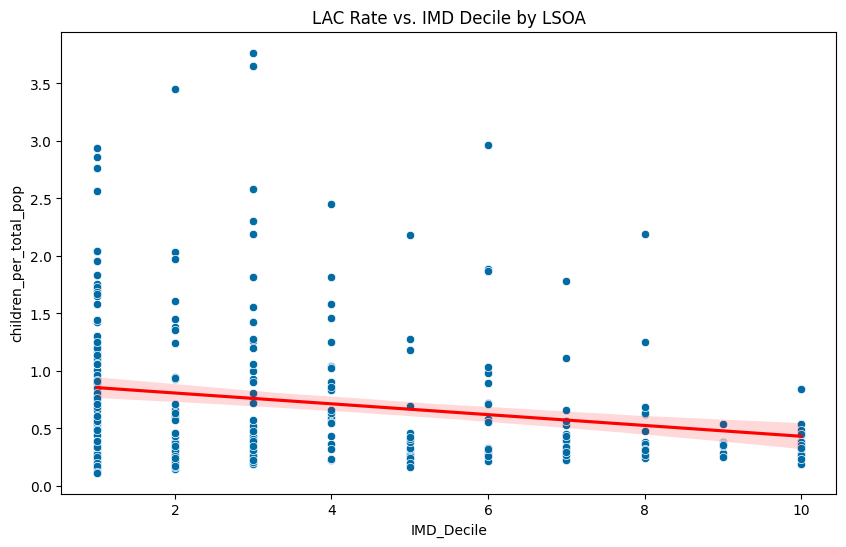

Pearson Correlation: -0.207 (p-value: 2.632e-04)
Spearman Correlation: -0.183 (p-value: 1.288e-03)

Linear Regression Results:
Slope: -0.047021
Intercept: 0.901
R-squared: 0.043
P-value: 2.632e-04


In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=children_population,
    x='IMD_Decile',
    y='children_per_total_pop',
)

# Add a trendline
sns.regplot(
    data=children_population,
    x='IMD_Decile',
    y='children_per_total_pop',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IMD Decile by LSOA')
plt.savefig("../figs/LAC_Rate_vs.IMD_Decile.png", dpi=300)
plt.show()


# Determine the relationship between IMD Decile and Proportion of LAC 


# Drop rows with NaN
valid = (
    children_population['IMD_Decile'].notna() &
    children_population['children_per_total_pop'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

The downward slope suggest that there's a negative correlation between the rate of LAC per population and the IMD rank.<br>
It appears to be a relationship between deprivation and rate of LAC, where more deprived areas tend to have more number of LAC & higher rates of LAC<br>
Small p-values indicates evidence of association between the variables - not by chance. <br>
Weak correlation coeeficients means that IMD rank is not a strong predictor of the proportion of children.<br>
Negative slope - Less deprived areas have less proportion of LAC<br>
R-squared value implies that only 6% of the variation in LAC rate is explained by the IMD Decile. Hence, other factors plays important roles in explainging the LAC rate per population.

In [33]:
most_deprived = children_population.loc[children_population['IMD_Decile'] == 1]
less_deprived = children_population.loc[children_population['IMD_Decile'] == 10]

children_in_deprived_areas = len(most_deprived)
children_in_less_deprived_areas = len(less_deprived)

print(f"Children in the most deprived area: {children_in_deprived_areas}")
print(f"Children in the less deprived area: {children_in_less_deprived_areas}\n")

children_in_deprived_areas = len(most_deprived)
children_in_less_deprived_areas = len(less_deprived)

if children_in_less_deprived_areas > 0:
    # Calculate the ratio: how many children in the most deprived area per one child in the less deprived area.
    ratio = children_in_deprived_areas / children_in_less_deprived_areas
    # Calculate what percentage the less deprived count is of the most deprived count.
    percentage = (children_in_less_deprived_areas / children_in_deprived_areas) * 100

    print(f"For every 1 child in the less deprived area, there are approximately {ratio:.1f} children in the most deprived area.")
    print(f"In percentage terms, children in the less deprived area represent about {percentage:.1f}% of those in the most deprived area.")
else:
    print("There are no children in the less deprived area to compare.")

Children in the most deprived area: 104
Children in the less deprived area: 16

For every 1 child in the less deprived area, there are approximately 6.5 children in the most deprived area.
In percentage terms, children in the less deprived area represent about 15.4% of those in the most deprived area.


### LAC Rate and IDCScore -  child-specific deprivation measure

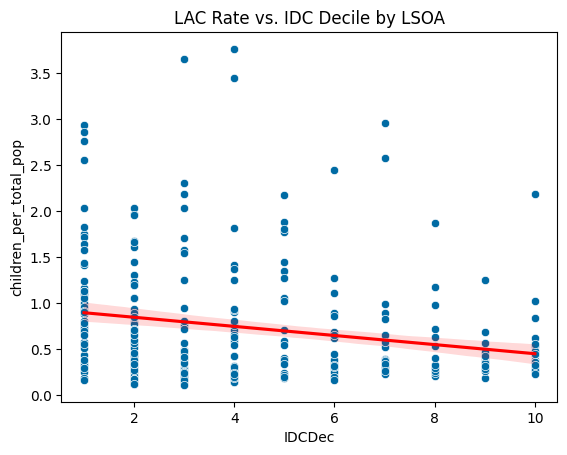

Pearson Correlation: -0.223 (p-value: 8.122e-05)
Spearman Correlation: -0.241 (p-value: 1.902e-05)

Linear Regression Results:
Slope: -0.049535
Intercept: 0.949
R-squared: 0.050
P-value: 8.122e-05


In [34]:
sns.scatterplot(
    data=clean_data,
    x='IDCDec',
    y='children_per_total_pop'
)

# Add a trendline
sns.regplot(
    data=clean_data,
    x='IDCDec',
    y='children_per_total_pop',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IDC Decile by LSOA')
plt.show()

# Determine the relationship between IDCDec and Proportion of LAC 

# Drop rows with NaN
valid = (
    children_population['IDCDec'].notna() &
    children_population['children_per_total_pop'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

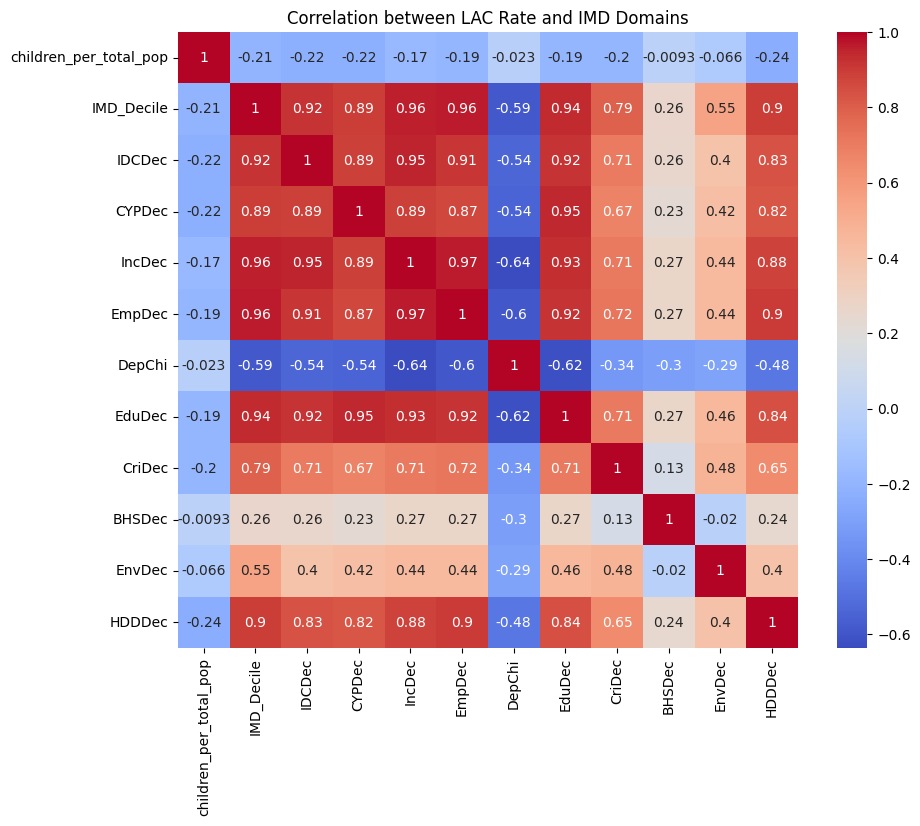

In [35]:
# Correlation Matric for IMD variables and lac rate per lsoa population
corr_matrix = clean_data[[
    'children_per_total_pop', 'IMD_Decile',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec', 'DepChi',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec', 'HDDDec'
]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between LAC Rate and IMD Domains')
plt.show()

### Correlation between LAC Population Rate and IMDs

In [36]:
import statsmodels.formula.api as smf

# 1. Define the formula for ordinary least squares (OLS) regression:
formula = "children_per_total_pop ~ DepChi + IncDec + EmpDec + EduDec + EnvDec + IDCDec + CriDec + HDDDec + CYPDec + BHSDec"

# 2. Fit the model
model = smf.ols(formula, data=children_population).fit()

# 3. Print a summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     children_per_total_pop   R-squared:                       0.111
Model:                                OLS   Adj. R-squared:                  0.081
Method:                     Least Squares   F-statistic:                     3.691
Date:                    Tue, 04 Mar 2025   Prob (F-statistic):           0.000113
Time:                            14:21:56   Log-Likelihood:                -283.54
No. Observations:                     308   AIC:                             589.1
Df Residuals:                         297   BIC:                             630.1
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

### Comparing Characteristics of children with intervention rates.

### Individual-Level

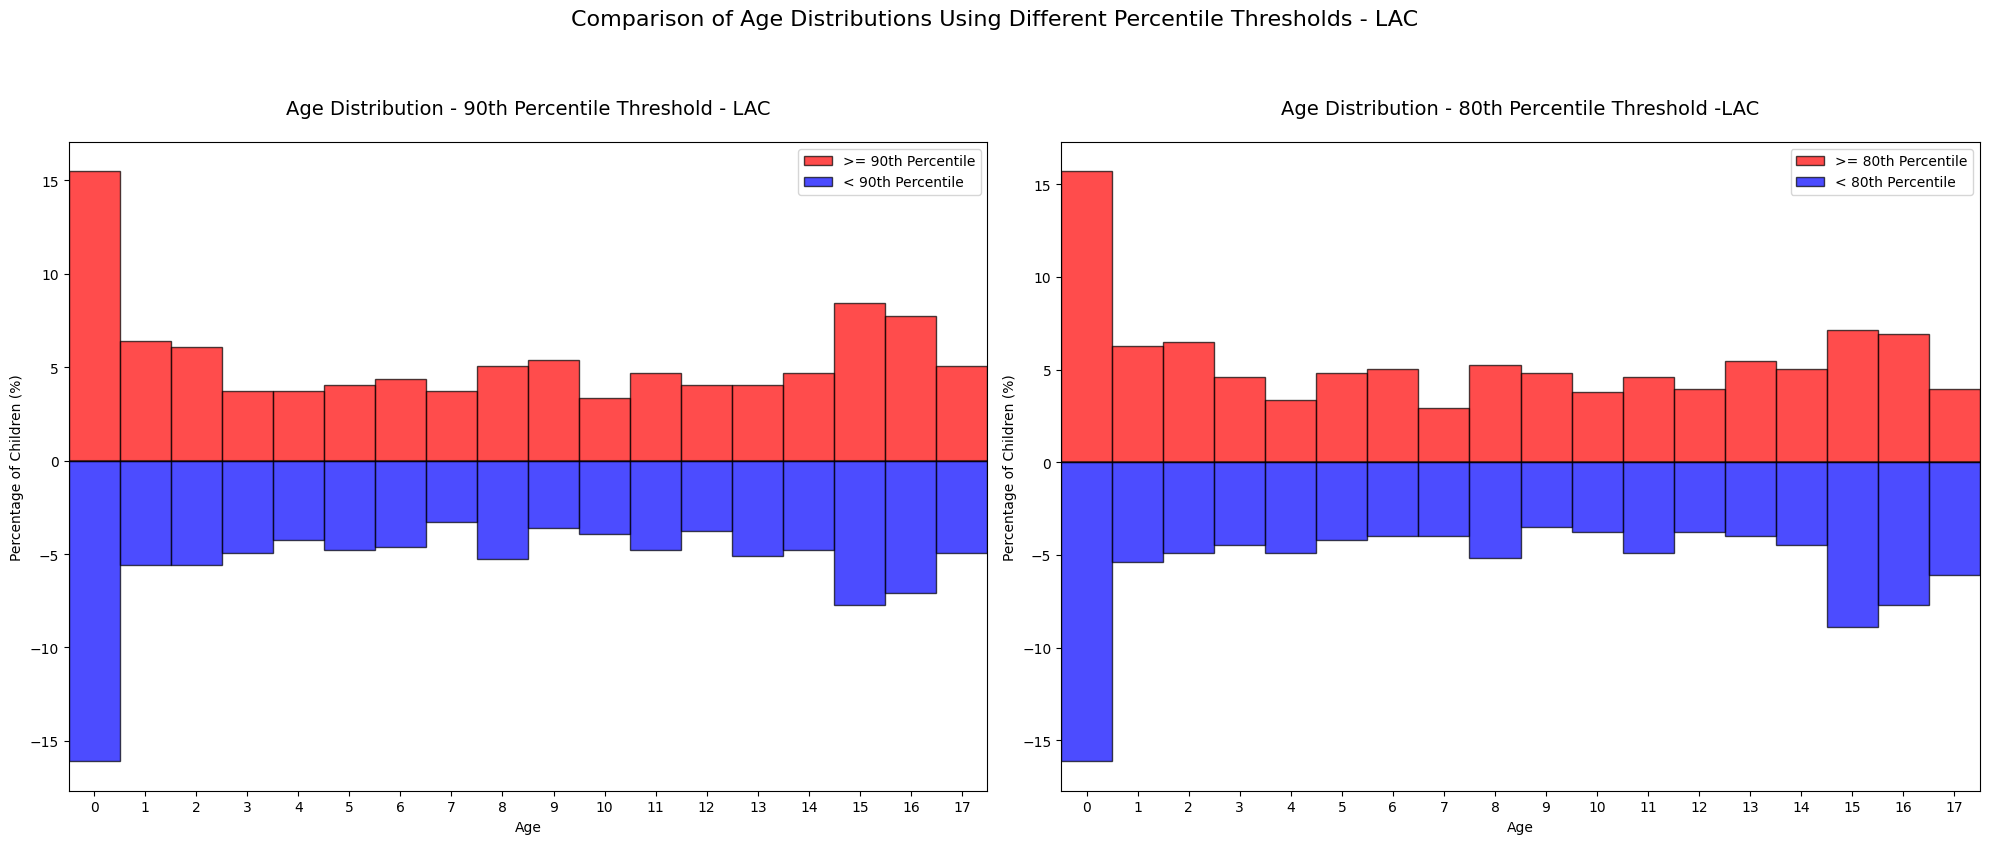

90th percentile cutoff value: 1.6060
Number of LSOAs above 90th percentile: 32
Number of children in high group (90th): 297
Number of children in other group (90th): 694


80th percentile cutoff value: 1.1048
Number of LSOAs above 80th percentile: 63
Number of children in high group (80th): 478
Number of children in other group (80th): 513


In [52]:
# Create a figure with two subplots side by side to compare 90th and 80th percentile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define bin edges for ages 0-17
bins = np.arange(0, 19) - 0.5  # Creates bin edges: [-0.5, 0.5, 1.5, ..., 18.5]
x = np.arange(18)
width = 1.0  # Full width to ensure bars touch

# First subplot - 90th percentile (your original code)
percentile_threshold_90 = 90
cutoff_value_90 = np.percentile(children_population['children_per_total_pop'], percentile_threshold_90)

# Select LSOAs above the 90th percentile threshold
high_intervention_lsoas_90 = children_population[children_population['children_per_total_pop'] >= cutoff_value_90]['lsoa21cd'].tolist()

# Split the data into high rate and other groups for 90th percentile
high_group_90 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]
other_group_90 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]

# Calculate histograms using counts for 90th percentile
high_counts_90, _ = np.histogram(high_group_90['age_at_entry'], bins=bins)
other_counts_90, _ = np.histogram(other_group_90['age_at_entry'], bins=bins)

# Convert counts to percentages for 90th percentile
high_pct_90 = high_counts_90 / high_counts_90.sum() * 100
other_pct_90 = other_counts_90 / other_counts_90.sum() * 100

# Plot the 90th percentile histogram
ax1.bar(x, high_pct_90, width=width, align='center', color='red', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='>= 90th Percentile')
ax1.bar(x, -other_pct_90, width=width, align='center', color='blue', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='< 90th Percentile')

# -------------------------------------------------------------------------------------------------
# Second subplot - 80th percentile
percentile_threshold_80 = 80
cutoff_value_80 = np.percentile(children_population['children_per_total_pop'], percentile_threshold_80)

# Select LSOAs above the 80th percentile threshold
high_intervention_lsoas_80 = children_population[children_population['children_per_total_pop'] >= cutoff_value_80]['lsoa21cd'].tolist()

# Split the data into high rate and other groups for 80th percentile
high_group_80 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]
other_group_80 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]

# Calculate histograms using counts for 80th percentile
high_counts_80, _ = np.histogram(high_group_80['age_at_entry'], bins=bins)
other_counts_80, _ = np.histogram(other_group_80['age_at_entry'], bins=bins)

# Convert counts to percentages for 80th percentile
high_pct_80 = high_counts_80 / high_counts_80.sum() * 100
other_pct_80 = other_counts_80 / other_counts_80.sum() * 100

# Plot the 80th percentile histogram
ax2.bar(x, high_pct_80, width=width, align='center', color='red', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='>= 80th Percentile')
ax2.bar(x, -other_pct_80, width=width, align='center', color='blue', alpha=0.7,
       edgecolor='black', linewidth=1.0,
       label='< 80th Percentile')

# Format the first subplot (90th percentile)
ax1.set_ylabel('Percentage of Children (%)')
ax1.set_xlabel('Age')
ax1.set_title('Age Distribution - 90th Percentile Threshold - LAC', fontsize=14, pad=20)
ax1.set_xlim(-0.5, 17.5)
ax1.set_xticks(x)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax1.legend(loc='upper right')

# Format the second subplot (80th percentile)
ax2.set_ylabel('Percentage of Children (%)')
ax2.set_xlabel('Age')
ax2.set_title('Age Distribution - 80th Percentile Threshold -LAC', fontsize=14, pad=20)
ax2.set_xlim(-0.5, 17.5)
ax2.set_xticks(x)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.legend(loc='upper right')

# Add an overall title
fig.suptitle('Comparison of Age Distributions Using Different Percentile Thresholds - LAC', fontsize=16, y=1.05)

# Adjust layout
plt.tight_layout()
plt.savefig(f'../figs/LAC_agedist_high_other.png', dpi=300)
plt.show()

# Print some statistics for comparison
print(f"90th percentile cutoff value: {cutoff_value_90:.4f}")
print(f"Number of LSOAs above 90th percentile: {len(high_intervention_lsoas_90)}")
print(f"Number of children in high group (90th): {len(high_group_90)}")
print(f"Number of children in other group (90th): {len(other_group_90)}")
print("\n")
print(f"80th percentile cutoff value: {cutoff_value_80:.4f}")
print(f"Number of LSOAs above 80th percentile: {len(high_intervention_lsoas_80)}")
print(f"Number of children in high group (80th): {len(high_group_80)}")
print(f"Number of children in other group (80th): {len(other_group_80)}")

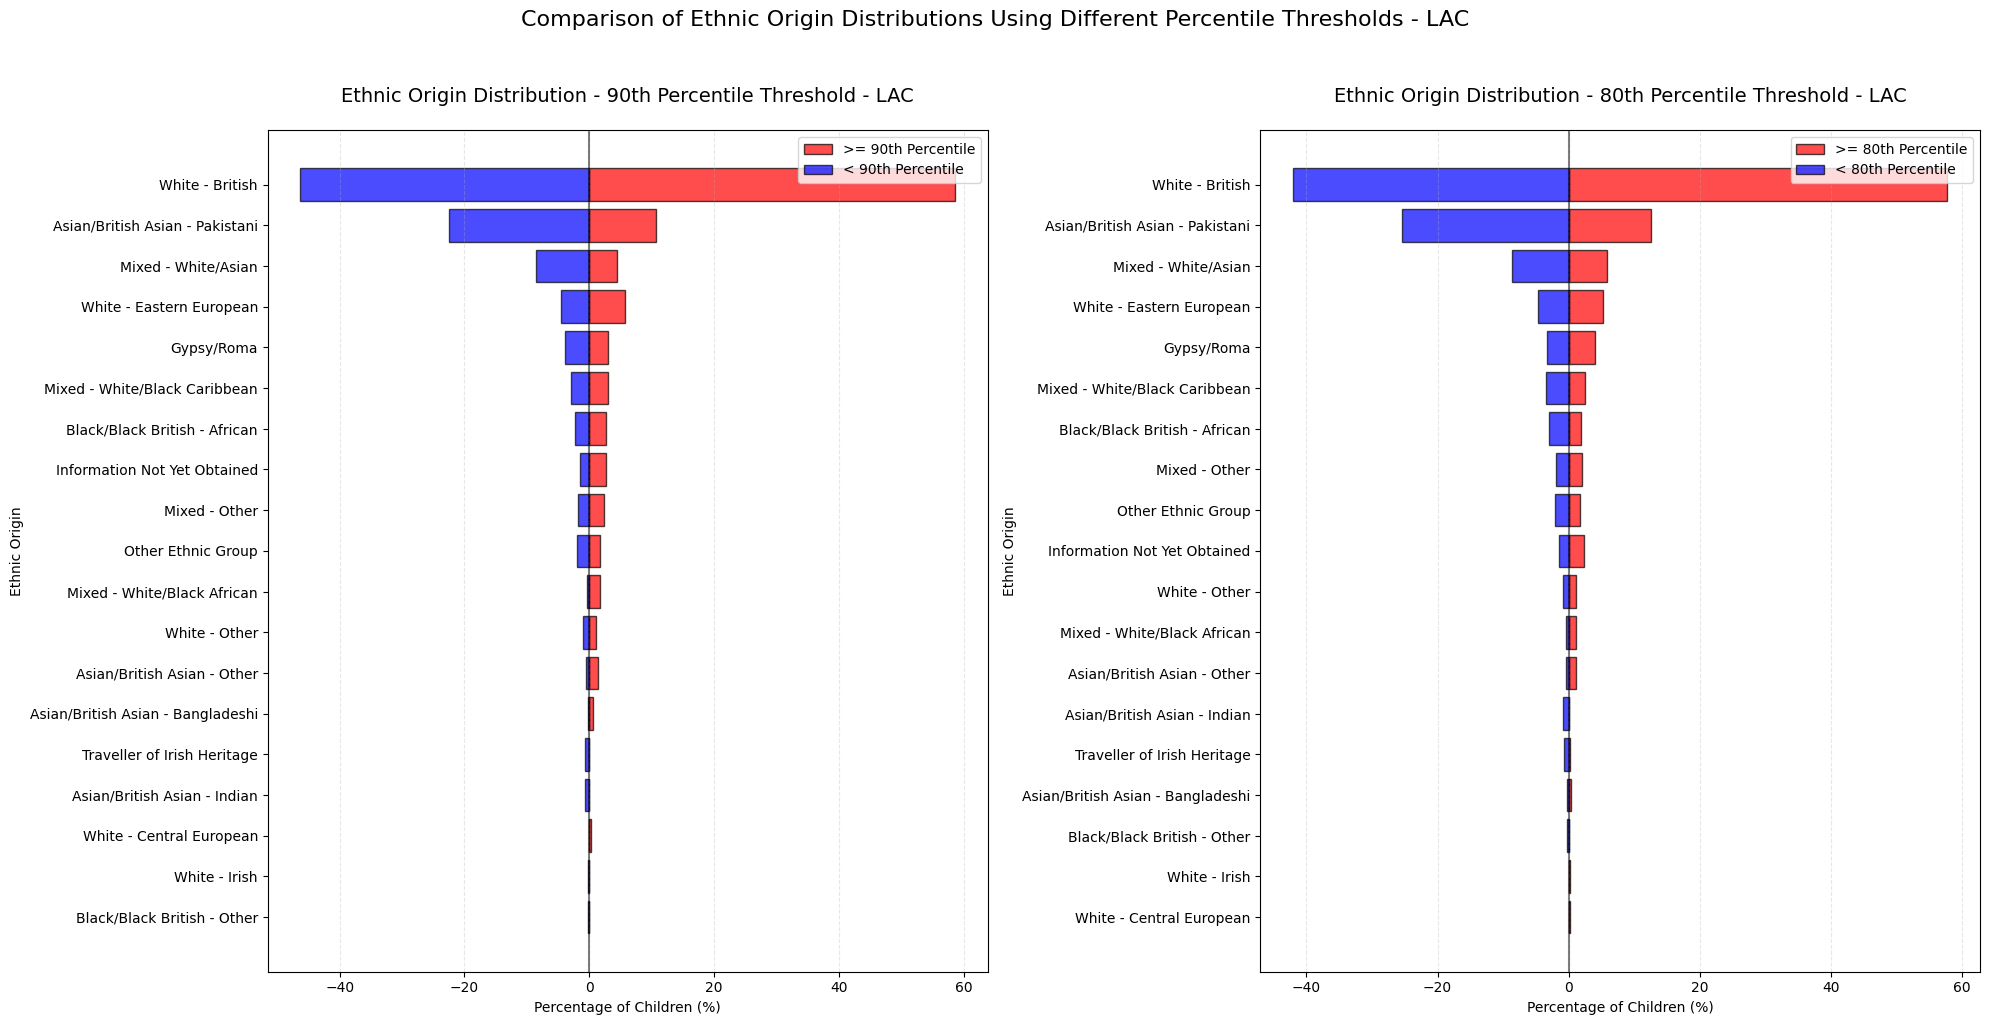

90th percentile cutoff value: 1.6060
Number of LSOAs above 90th percentile: 32
Number of children in high group (90th): 297
Number of children in other group (90th): 694


80th percentile cutoff value: 1.1048
Number of LSOAs above 80th percentile: 63
Number of children in high group (80th): 478
Number of children in other group (80th): 513


In [53]:
# Create a figure with two subplots side by side to compare 90th and 80th percentile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Define the percentile thresholds
percentile_threshold_90 = 90
percentile_threshold_80 = 80

# Calculate cutoff values
cutoff_value_90 = np.percentile(children_population['children_per_total_pop'], percentile_threshold_90)
cutoff_value_80 = np.percentile(children_population['children_per_total_pop'], percentile_threshold_80)

# Select LSOAs above the percentile thresholds
high_intervention_lsoas_90 = children_population[children_population['children_per_total_pop'] >= cutoff_value_90]['lsoa21cd'].tolist()
high_intervention_lsoas_80 = children_population[children_population['children_per_total_pop'] >= cutoff_value_80]['lsoa21cd'].tolist()

# Split the data into high rate and other groups for both percentiles
high_group_90 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]
other_group_90 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_90)]

high_group_80 = merged_data[merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]
other_group_80 = merged_data[~merged_data['lsoa21cd'].isin(high_intervention_lsoas_80)]

# Process for 90th percentile (left subplot)
# Get the counts for each ethnic origin category
high_ethnicity_counts_90 = high_group_90['EthnicOrigin'].value_counts()
other_ethnicity_counts_90 = other_group_90['EthnicOrigin'].value_counts()

# Convert to percentages
high_ethnicity_pct_90 = high_ethnicity_counts_90 / high_ethnicity_counts_90.sum() * 100
other_ethnicity_pct_90 = other_ethnicity_counts_90 / other_ethnicity_counts_90.sum() * 100

# Combine the categories to ensure both groups have the same categories
all_categories_90 = sorted(set(high_ethnicity_pct_90.index) | set(other_ethnicity_pct_90.index))

# Reindex to include all categories, filling missing values with 0
high_ethnicity_pct_90 = high_ethnicity_pct_90.reindex(all_categories_90, fill_value=0)
other_ethnicity_pct_90 = other_ethnicity_pct_90.reindex(all_categories_90, fill_value=0)

# Sort categories by total percentage (high + other) in descending order
total_pct_90 = high_ethnicity_pct_90 + other_ethnicity_pct_90
sorted_categories_90 = total_pct_90.sort_values(ascending=True).index  # Ascending for bottom-to-top

# Reindex according to sorted order
high_ethnicity_pct_90 = high_ethnicity_pct_90.reindex(sorted_categories_90)
other_ethnicity_pct_90 = other_ethnicity_pct_90.reindex(sorted_categories_90)

# Process for 80th percentile (right subplot)
# Get the counts for each ethnic origin category
high_ethnicity_counts_80 = high_group_80['EthnicOrigin'].value_counts()
other_ethnicity_counts_80 = other_group_80['EthnicOrigin'].value_counts()

# Convert to percentages
high_ethnicity_pct_80 = high_ethnicity_counts_80 / high_ethnicity_counts_80.sum() * 100
other_ethnicity_pct_80 = other_ethnicity_counts_80 / other_ethnicity_counts_80.sum() * 100

# Combine the categories to ensure both groups have the same categories
all_categories_80 = sorted(set(high_ethnicity_pct_80.index) | set(other_ethnicity_pct_80.index))

# Reindex to include all categories, filling missing values with 0
high_ethnicity_pct_80 = high_ethnicity_pct_80.reindex(all_categories_80, fill_value=0)
other_ethnicity_pct_80 = other_ethnicity_pct_80.reindex(all_categories_80, fill_value=0)

# Sort categories by total percentage (high + other) in descending order
total_pct_80 = high_ethnicity_pct_80 + other_ethnicity_pct_80
sorted_categories_80 = total_pct_80.sort_values(ascending=True).index  # Ascending for bottom-to-top

# Reindex according to sorted order
high_ethnicity_pct_80 = high_ethnicity_pct_80.reindex(sorted_categories_80)
other_ethnicity_pct_80 = other_ethnicity_pct_80.reindex(sorted_categories_80)

# Create horizontal bars for 90th percentile (left subplot)
y_pos_90 = np.arange(len(sorted_categories_90))
width = 0.8  # Bar width

ax1.barh(y_pos_90, high_ethnicity_pct_90, height=width, color='red', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='>= 90th Percentile')
ax1.barh(y_pos_90, -other_ethnicity_pct_90, height=width, color='blue', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='< 90th Percentile')

# Create horizontal bars for 80th percentile (right subplot)
y_pos_80 = np.arange(len(sorted_categories_80))

ax2.barh(y_pos_80, high_ethnicity_pct_80, height=width, color='red', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='>= 80th Percentile')
ax2.barh(y_pos_80, -other_ethnicity_pct_80, height=width, color='blue', alpha=0.7,
         edgecolor='black', linewidth=1.0, label='< 80th Percentile')

# Format the first subplot (90th percentile)
ax1.set_xlabel('Percentage of Children (%)')
ax1.set_ylabel('Ethnic Origin')
ax1.set_title('Ethnic Origin Distribution - 90th Percentile Threshold - LAC', fontsize=14, pad=20)
ax1.set_yticks(y_pos_90)
ax1.set_yticklabels(sorted_categories_90)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax1.grid(axis='x', linestyle='--', alpha=0.3)
ax1.legend(loc='upper right')

# Format the second subplot (80th percentile)
ax2.set_xlabel('Percentage of Children (%)')
ax2.set_ylabel('Ethnic Origin')
ax2.set_title('Ethnic Origin Distribution - 80th Percentile Threshold - LAC', fontsize=14, pad=20)
ax2.set_yticks(y_pos_80)
ax2.set_yticklabels(sorted_categories_80)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(axis='x', linestyle='--', alpha=0.3)
ax2.legend(loc='upper right')

# Add an overall title
fig.suptitle('Comparison of Ethnic Origin Distributions Using Different Percentile Thresholds - LAC', fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'../figs/LAC_ethnicity_dist_high_other.png', dpi=300)
plt.show()

# Print some statistics for comparison
print(f"90th percentile cutoff value: {cutoff_value_90:.4f}")
print(f"Number of LSOAs above 90th percentile: {len(high_intervention_lsoas_90)}")
print(f"Number of children in high group (90th): {len(high_group_90)}")
print(f"Number of children in other group (90th): {len(other_group_90)}")
print("\n")
print(f"80th percentile cutoff value: {cutoff_value_80:.4f}")
print(f"Number of LSOAs above 80th percentile: {len(high_intervention_lsoas_80)}")
print(f"Number of children in high group (80th): {len(high_group_80)}")
print(f"Number of children in other group (80th): {len(other_group_80)}")

### Area Level

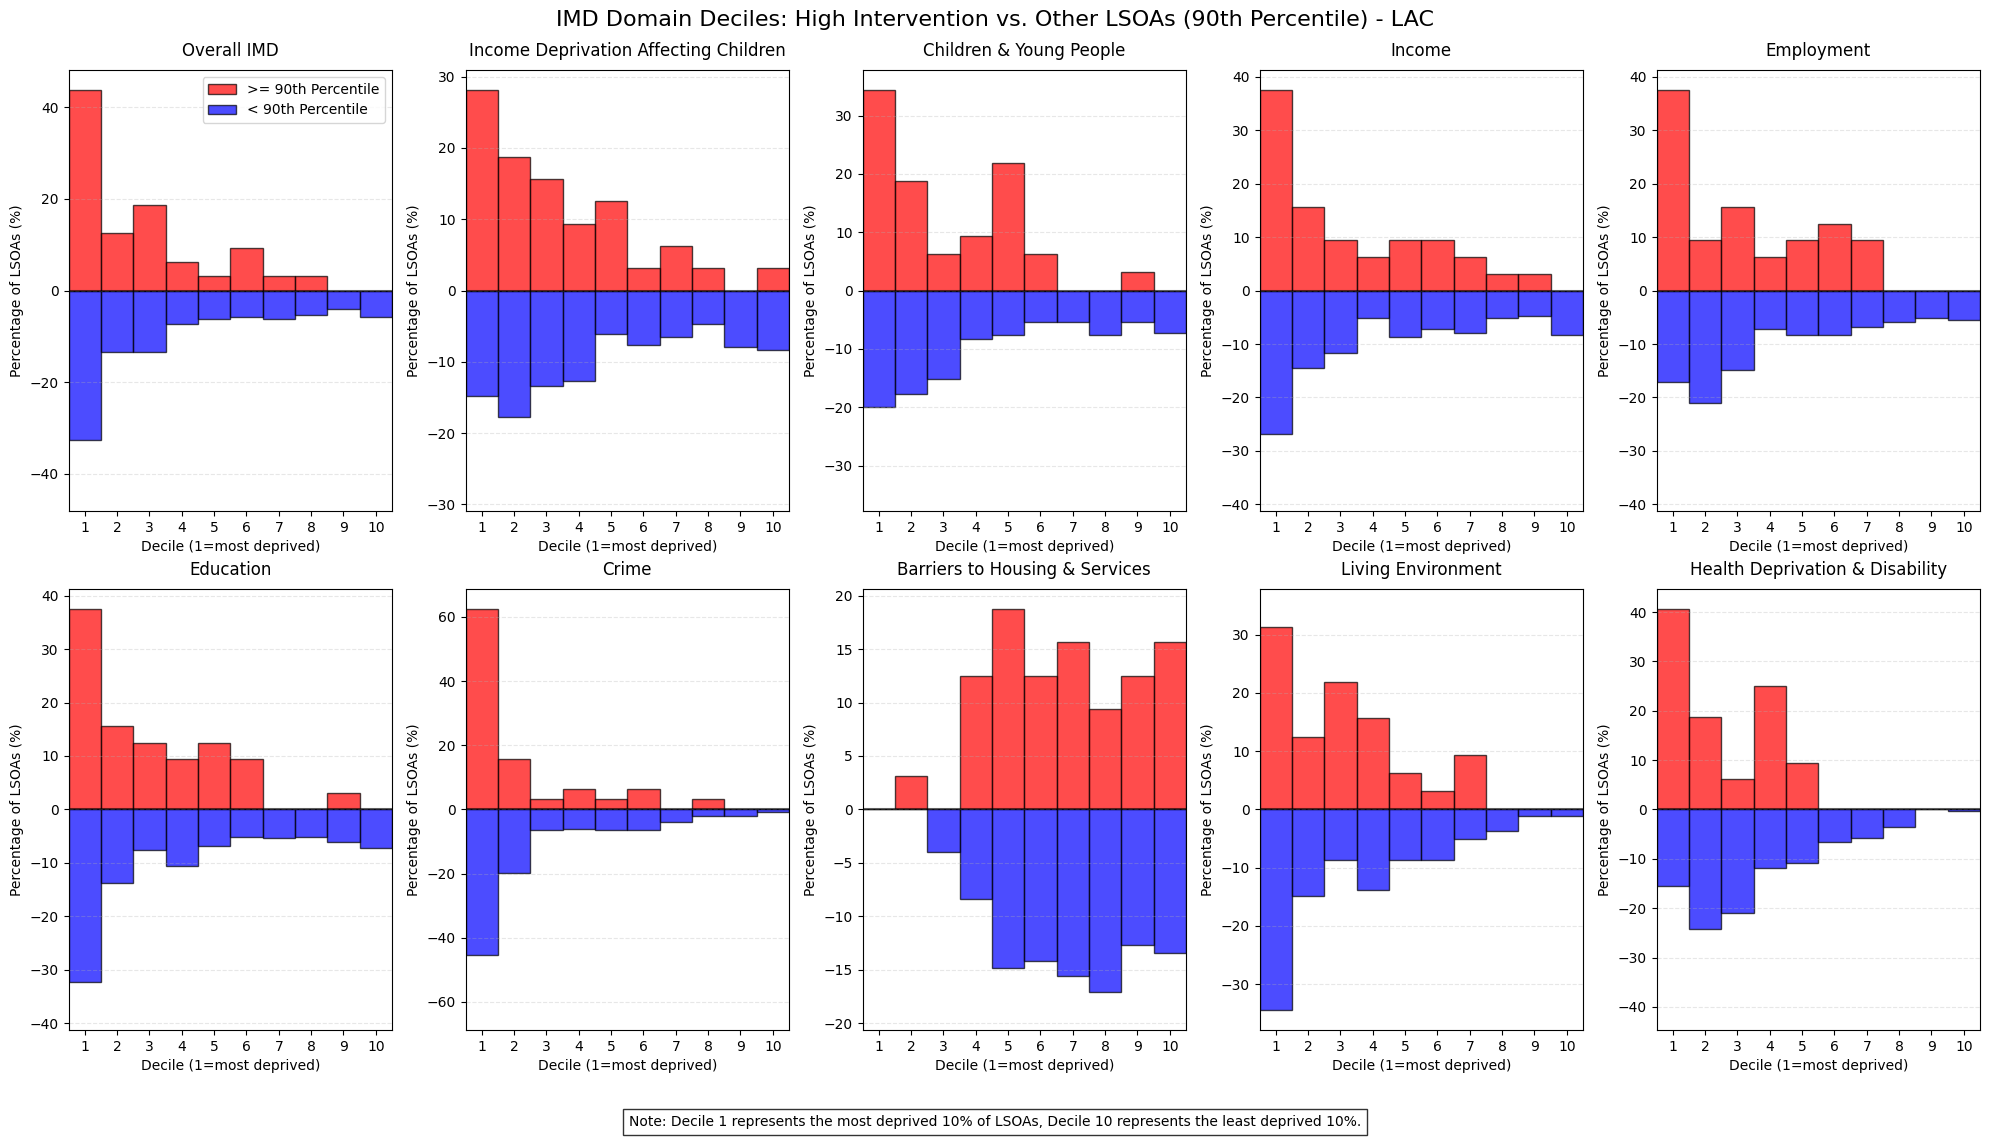

In [54]:
# First, calculate the intervention rate threshold for the 90th percentile
percentile_threshold = 90
cutoff_value = np.percentile(children_population['children_per_total_pop'], percentile_threshold)

# Identify high-intervention LSOAs (top 10%)
children_population['high_intervention'] = children_population['children_per_total_pop'] >= cutoff_value

# Split into high and other groups
high_lsoa_group = children_population[children_population['high_intervention']]
other_lsoa_group = children_population[~children_population['high_intervention']]

# List of IMD domains to analyze (using the deciles)
imd_domains = ['IMD_Decile', 'IDCDec', 'CYPDec', 'IncDec', 'EmpDec',
               'EduDec', 'CriDec', 'BHSDec', 'EnvDec', 'HDDDec']

# Create a dictionary to map domain codes to more readable names
domain_names = {
    'IMD_Decile': 'Overall IMD',
    'IDCDec': 'Income Deprivation Affecting Children',
    'CYPDec': 'Children & Young People',
    'IncDec': 'Income',
    'EmpDec': 'Employment',
    'EduDec': 'Education',
    'CriDec': 'Crime',
    'BHSDec': 'Barriers to Housing & Services',
    'EnvDec': 'Living Environment',
    'HDDDec': 'Health Deprivation & Disability'
}

# Create a figure with multiple subplots - one for each domain
fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle('IMD Domain Deciles: High Intervention vs. Other LSOAs (90th Percentile) - LAC',
             fontsize=16, y=0.95)

# For each domain, create a vertical mirrored histogram
for i, domain in enumerate(imd_domains):
    ax = axes[i]

    # Calculate the distribution of deciles for high and other LSOAs
    high_counts = high_lsoa_group[domain].value_counts().sort_index()
    other_counts = other_lsoa_group[domain].value_counts().sort_index()

    # Convert to percentages
    high_pct = high_counts / high_counts.sum() * 100
    other_pct = other_counts / other_counts.sum() * 100

    # Ensure all deciles (1-10) are represented
    all_deciles = range(1, 11)
    high_pct = high_pct.reindex(all_deciles, fill_value=0)
    other_pct = other_pct.reindex(all_deciles, fill_value=0)

    # Create vertical bars with width=1.0 to ensure they touch
    x_pos = np.arange(0.5, 10.5)  # Position bars at 0.5, 1.5, ..., 9.5
    width = 1.0  # Full width to ensure bars touch

    # Plot vertical bars
    ax.bar(x_pos, high_pct, width=width, color='red', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='>= 90th Percentile', align='center')
    ax.bar(x_pos, -other_pct, width=width, color='blue', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='< 90th Percentile', align='center')

    # Add labels and formatting
    ax.set_ylabel('Percentage of LSOAs (%)')
    ax.set_xlabel('Decile (1=most deprived)')
    ax.set_title(f'{domain_names[domain]}', fontsize=12, pad=10)

    # Set x-ticks at the center of each bar
    ax.set_xticks(x_pos)
    ax.set_xticklabels(range(1, 11))

    # Set x-limits to ensure bars are fully visible
    ax.set_xlim(0, 10)

    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to be symmetric
    y_max = max(high_pct.max(), other_pct.max()) * 1.1
    ax.set_ylim(-y_max, y_max)

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(loc='upper right')

# Add note about deciles
fig.text(0.5, 0.02,
         'Note: Decile 1 represents the most deprived 10% of LSOAs, Decile 10 represents the least deprived 10%.',
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig(f'../figs/LAC_IMDs_dist_high_other_groups_90th.png', dpi=300)
plt.show()

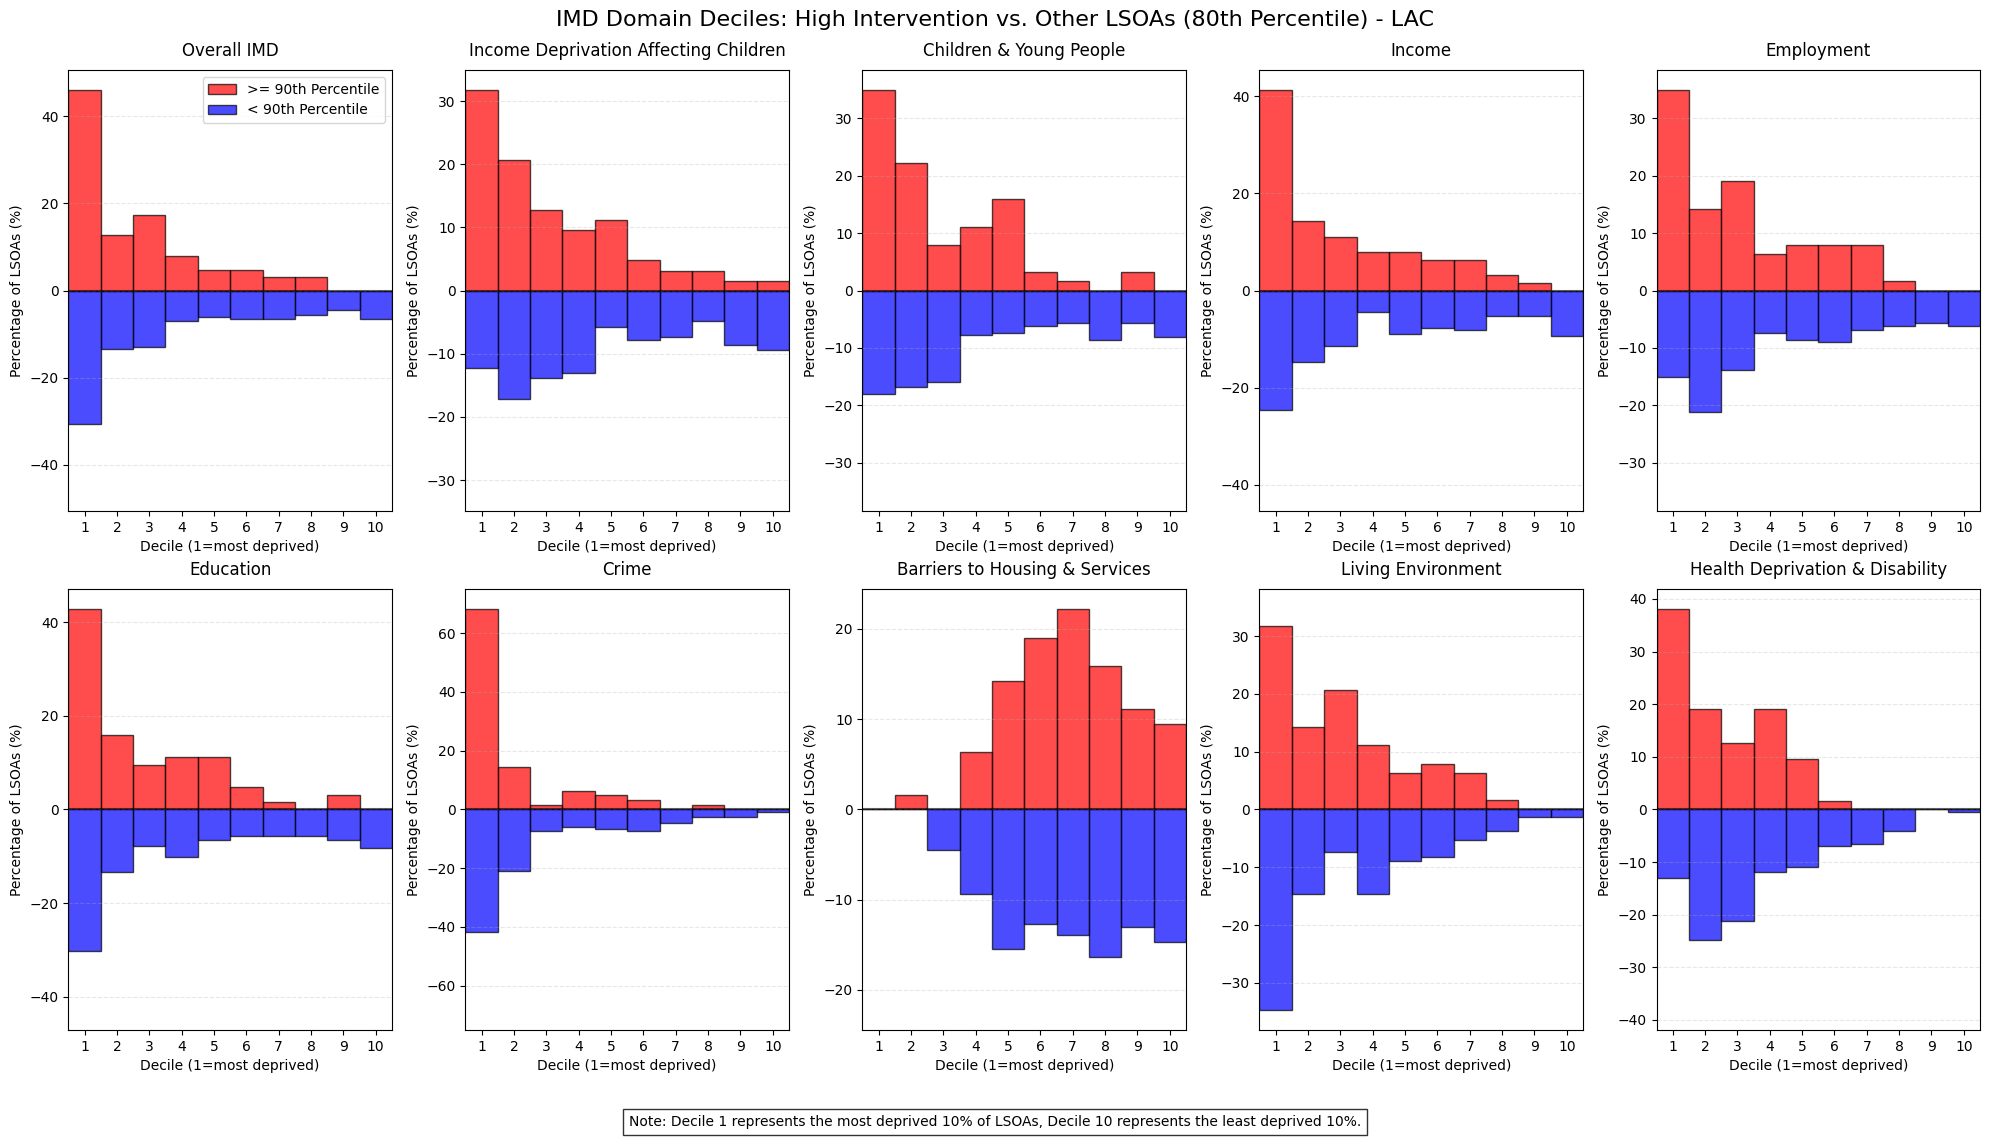

In [55]:
# First, calculate the intervention rate threshold for the 90th percentile
percentile_threshold = 80
cutoff_value = np.percentile(children_population['children_per_total_pop'], percentile_threshold)

# Identify high-intervention LSOAs (top 10%)
children_population['high_intervention'] = children_population['children_per_total_pop'] >= cutoff_value

# Split into high and other groups
high_lsoa_group = children_population[children_population['high_intervention']]
other_lsoa_group = children_population[~children_population['high_intervention']]

# Create a figure with multiple subplots - one for each domain
fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle('IMD Domain Deciles: High Intervention vs. Other LSOAs (80th Percentile) - LAC',
             fontsize=16, y=0.95)

# For each domain, create a vertical mirrored histogram
for i, domain in enumerate(imd_domains):
    ax = axes[i]

    # Calculate the distribution of deciles for high and other LSOAs
    high_counts = high_lsoa_group[domain].value_counts().sort_index()
    other_counts = other_lsoa_group[domain].value_counts().sort_index()

    # Convert to percentages
    high_pct = high_counts / high_counts.sum() * 100
    other_pct = other_counts / other_counts.sum() * 100

    # Ensure all deciles (1-10) are represented
    all_deciles = range(1, 11)
    high_pct = high_pct.reindex(all_deciles, fill_value=0)
    other_pct = other_pct.reindex(all_deciles, fill_value=0)

    # Create vertical bars with width=1.0 to ensure they touch
    x_pos = np.arange(0.5, 10.5)  # Position bars at 0.5, 1.5, ..., 9.5
    width = 1.0  # Full width to ensure bars touch

    # Plot vertical bars
    ax.bar(x_pos, high_pct, width=width, color='red', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='>= 90th Percentile', align='center')
    ax.bar(x_pos, -other_pct, width=width, color='blue', alpha=0.7,
           edgecolor='black', linewidth=1.0, label='< 90th Percentile', align='center')

    # Add labels and formatting
    ax.set_ylabel('Percentage of LSOAs (%)')
    ax.set_xlabel('Decile (1=most deprived)')
    ax.set_title(f'{domain_names[domain]}', fontsize=12, pad=10)

    # Set x-ticks at the center of each bar
    ax.set_xticks(x_pos)
    ax.set_xticklabels(range(1, 11))

    # Set x-limits to ensure bars are fully visible
    ax.set_xlim(0, 10)

    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Set y-axis limits to be symmetric
    y_max = max(high_pct.max(), other_pct.max()) * 1.1
    ax.set_ylim(-y_max, y_max)

    # Add legend only to the first subplot
    if i == 0:
        ax.legend(loc='upper right')

# Add note about deciles
fig.text(0.5, 0.02,
         'Note: Decile 1 represents the most deprived 10% of LSOAs, Decile 10 represents the least deprived 10%.',
         ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig(f'../figs/LAC_IMDs_dist_high_other_groups_80th.png', dpi=300)
plt.show()